Cortex EAL: 279.0058413649777 microns
Relative White Matter EAL: 150.02493648069424 microns


/Users/michaelthornton/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


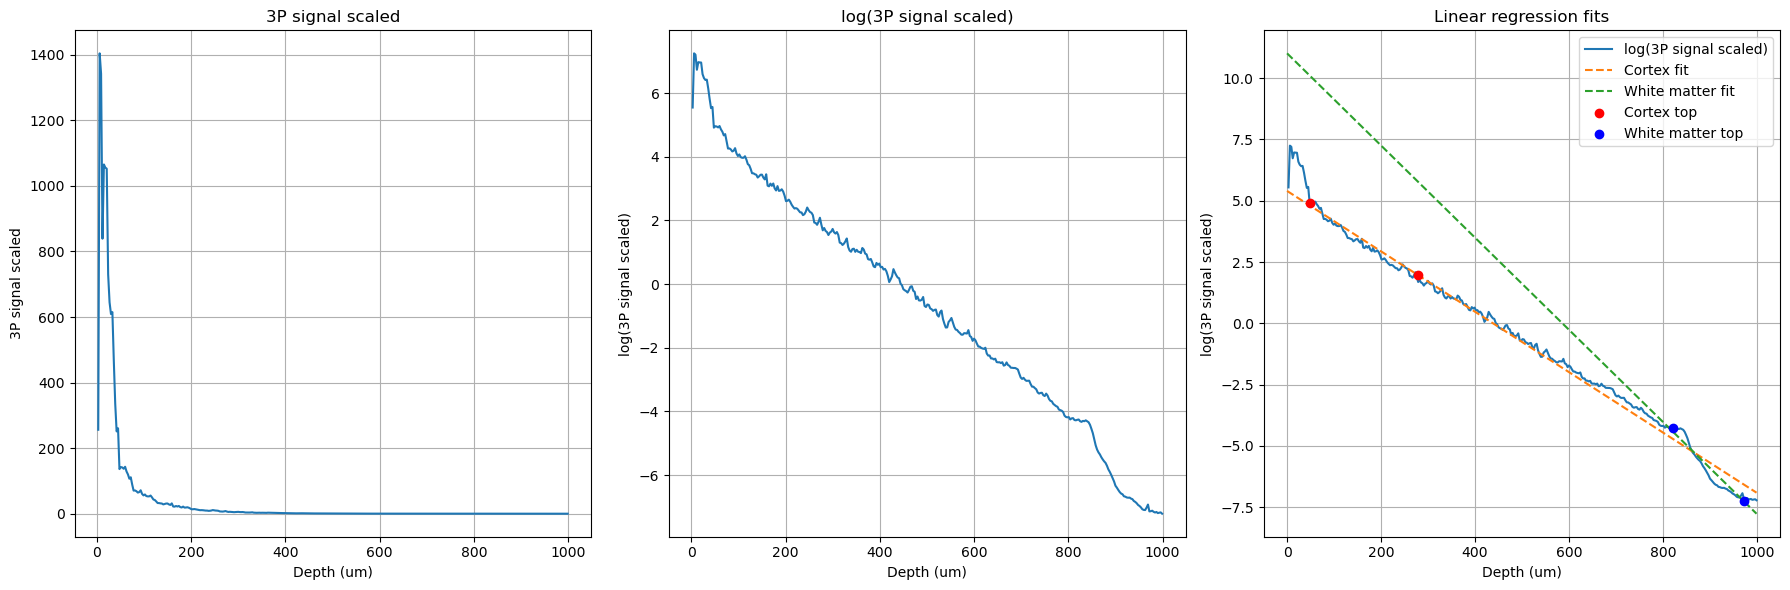

In [9]:
#Michael Thornton, Ph.D., Ethan Hughes Lab, 2024
#Related to Thornton et al., 2024; https://www.nature.com/articles/s41593-024-01613-7
#This code calculates the effective attenuation length of mouse brain based on fluorescent signal collected across depth with three-photon excitation
#The code takes an excel spreadsheet with three columns: 1) depth in microns of each z-slice, 2) power (mW) at each z-slice, and 3) the mean intensity of the top 1% of pixels at each z-slice
#The top n % pixels is measured using the ImageJ macro "mean_of_brightest_n_pixels_v105.ijm" that is available from the NYU Langone Imaging Core and Michael Cammer, at https://microscopynotes.com/imagej/
#After calculating the EALs based on linear regression for the gray and white matter, the code uses these values to return a mouse-specific power curve
#that increases linearly, starting from 0 mW, from 0 micron to cortex_top, then using the equation Power at the surface (mW) = rep. rate * Power at the focus (mW) * e^(-z / EAL)
#While 2nJ has been empirically shown to be safe from inducing nonlinear tissue damage in our system, this can vary by preparation, and the exported power curve does not take into account brain heating or other factors that can still damage the mouse brain. This is just a guideline power vs. depth curve. 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Define the parameters
file_path = '/Users/michaelthornton/Desktop/EAL data for Gibson Lab/Data/MT158_110320_EAL.xlsx'
repetition_rate = 1  # MHz
cortex_top = 48  # microns
white_matter_top = 822  # microns

def calculate_eal(file_path, repetition_rate, cortex_top, white_matter_top):
    # Load the data file
    df = pd.read_excel(file_path)

    # Convert the column "Average Power (mW) no overscan" to pulse energy at the surface
    df['Pulse energy at the surface (nJ)'] = df['Average Power (mW) no overscan'] / repetition_rate

    # Divide the column "Mean top 1% of pixels" by the cube of the column "Pulse energy at the surface (nJ)"
    df['3P signal scaled'] = df['Mean top 1% of pixels'] / (df['Pulse energy at the surface (nJ)'] ** 3)

    # Take the logarithm of the "3P signal scaled"
    df['log(3P signal scaled)'] = np.log(df['3P signal scaled'])

    # Perform linear regression for the cortex and white matter regions
    cortex_data = df[df['Depth (um)'] >= cortex_top]
    white_matter_data = df[df['Depth (um)'] >= white_matter_top]

    cortex_slope, cortex_intercept, _, _, _ = linregress(cortex_data['Depth (um)'], cortex_data['log(3P signal scaled)'])
    white_matter_slope, white_matter_intercept, _, _, _ = linregress(white_matter_data['Depth (um)'], white_matter_data['log(3P signal scaled)'])

    # Calculate the maximum signal in the cortex and white matter regions
    max_signal_cortex = cortex_data['3P signal scaled'].max()
    max_signal_white_matter = white_matter_data['3P signal scaled'].max()

    # Calculate the depth at which the signal decays to 1/e^3 of the maximum signal
    decay_threshold_cortex = max_signal_cortex / np.exp(3)
    decay_threshold_white_matter = max_signal_white_matter / np.exp(3)

    def find_eal_from_log_fit(slope, intercept, decay_threshold):
        log_decay_threshold = np.log(decay_threshold)
        eal_depth = (log_decay_threshold - intercept) / slope
        return eal_depth

    cortex_eal_depth = find_eal_from_log_fit(cortex_slope, cortex_intercept, decay_threshold_cortex)
    white_matter_eal_depth = find_eal_from_log_fit(white_matter_slope, white_matter_intercept, decay_threshold_white_matter)

    # Subtract white_matter_top from the calculated EAL for white matter
    relative_white_matter_eal_depth = white_matter_eal_depth - white_matter_top

    return df, cortex_eal_depth, relative_white_matter_eal_depth, cortex_slope, cortex_intercept, white_matter_slope, white_matter_intercept, decay_threshold_cortex, decay_threshold_white_matter

# Calculate the EAL values
df, cortex_eal_depth, relative_white_matter_eal_depth, cortex_slope, cortex_intercept, white_matter_slope, white_matter_intercept, decay_threshold_cortex, decay_threshold_white_matter = calculate_eal(file_path, repetition_rate, cortex_top, white_matter_top)

# Print the results
print(f"Cortex EAL: {cortex_eal_depth} microns")
print(f"Relative White Matter EAL: {relative_white_matter_eal_depth} microns")

# Plotting
plt.figure(figsize=(18, 6))

# Plot 1: 3P signal scaled
plt.subplot(1, 3, 1)
plt.plot(df['Depth (um)'], df['3P signal scaled'], label='3P signal scaled')
plt.xlabel('Depth (um)')
plt.ylabel('3P signal scaled')
plt.title('3P signal scaled')
plt.grid(True)

# Plot 2: log(3P signal scaled)
plt.subplot(1, 3, 2)
plt.plot(df['Depth (um)'], df['log(3P signal scaled)'], label='log(3P signal scaled)')
plt.xlabel('Depth (um)')
plt.ylabel('log(3P signal scaled)')
plt.title('log(3P signal scaled)')
plt.grid(True)

# Plot 3: Linear regression fits on the log plot
plt.subplot(1, 3, 3)
plt.plot(df['Depth (um)'], df['log(3P signal scaled)'], label='log(3P signal scaled)')
plt.plot(df['Depth (um)'], cortex_slope * df['Depth (um)'] + cortex_intercept, label='Cortex fit', linestyle='--')
plt.plot(df['Depth (um)'], white_matter_slope * df['Depth (um)'] + white_matter_intercept, label='White matter fit', linestyle='--')

# Plot points where the decay threshold is reached
plt.scatter([cortex_eal_depth], [np.log(decay_threshold_cortex)], color='red', zorder=5)
plt.scatter([white_matter_eal_depth], [np.log(decay_threshold_white_matter)], color='blue', zorder=5)

# Plot points at cortex_top and white_matter_top
plt.scatter([cortex_top], [np.log(df[df['Depth (um)'] == cortex_top]['3P signal scaled'])], color='red', marker='o', label='Cortex top', zorder=5)
plt.scatter([white_matter_top], [np.log(df[df['Depth (um)'] == white_matter_top]['3P signal scaled'])], color='blue', marker='o', label='White matter top', zorder=5)

plt.xlabel('Depth (um)')
plt.ylabel('log(3P signal scaled)')
plt.title('Linear regression fits')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


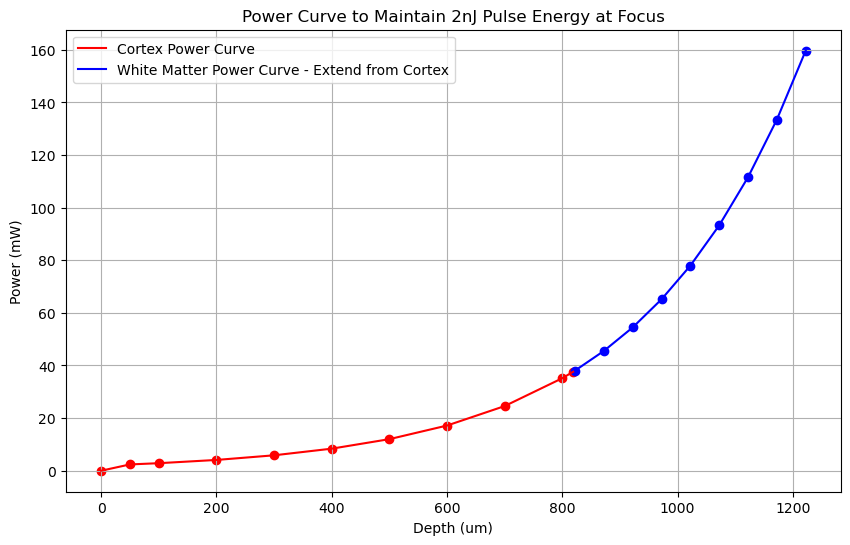

    Depth (um)  Power (mW)
0            0    0.000000
1           50    2.392538
2          100    2.862120
3          200    4.095866
4          300    5.861429
5          400    8.388057
6          500   12.003813
7          600   17.178177
8          700   24.583002
9          800   35.179751
10         819   37.658911
11         822   38.066021
12         872   45.537209
13         922   54.474761
14         972   65.166479
15        1022   77.956652
16        1072   93.257142
17        1122  111.560647
18        1172  133.456566
19        1222  159.649980


In [17]:
#Create power curves for cortex and white matter that maintain 2nJ pulse energy at the focus, based on the calculated EALs

desired_pulse_energy = 2  # nJ
total_depth_zstack = 1200 #micron

# Generate the power curve
depths_cortex = np.array([0, 50, 100, 200, 300, 400, 500, 600, 700, 800, white_matter_top - 3])
depths_extended = np.arange(white_matter_top, total_depth_zstack + 50, 50)

power_cortex = np.zeros_like(depths_cortex, dtype=float)
power_extended = np.zeros_like(depths_extended, dtype=float)

# Calculate power curve for cortex
for i, depth in enumerate(depths_cortex):
    if depth < cortex_top:
        power_cortex[i] = 0
    else:
        power_cortex[i] = desired_pulse_energy * np.exp(depth / cortex_eal_depth) * repetition_rate

# Extend the cortex power curve using the cortex EAL fit
for i, depth in enumerate(depths_extended):
    power_extended[i] = desired_pulse_energy * np.exp(depth / cortex_eal_depth) * repetition_rate

# Create a dataframe for the power values
power_data = pd.DataFrame({
    'Depth (um)': np.concatenate([depths_cortex, depths_extended]),
    'Power (mW)': np.concatenate([power_cortex, power_extended])
})

# Plotting the power curve
plt.figure(figsize=(10, 6))
plt.plot(depths_cortex, power_cortex, label='Cortex Power Curve', color='red')
plt.plot(depths_extended, power_extended, label='White Matter Power Curve - Extend from Cortex', color='blue')
plt.scatter(depths_cortex, power_cortex, color='red')
plt.scatter(depths_extended, power_extended, color='blue')
plt.xlabel('Depth (um)')
plt.ylabel('Power (mW)')
plt.title('Power Curve to Maintain 2nJ Pulse Energy at Focus')
plt.legend()
plt.grid(True)
plt.show()

# Print the dataframe
print(power_data)

